# A Python interface to PISA!

The [PISA Engine](https://github.com/pisa-engine/pisa) provides blazing-fast retrieval over sparse indices. This is helpful for all sorts of things, including initial candidate set generation for neural re-ranking.

Our inteface adheres with the [PyTerrier API](https://pyterrier.readthedocs.io/en/latest/), which makes it simple to combine PISA retrieval with loads of other tools.

To start using it, you can install it from the pypi `pyterrier_pisa` package.

In [ ]:
!pip install -q pyterrier-pisa==0.0.3

     |████████████████████████████████| 4.6 MB 7.6 MB/s 


We'll first import everything that we'll need.

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()
from pyterrier_pisa import PisaIndex
from pyterrier.measures import *

PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



`PisaIndex` is the main class for the interface. You can create an index just by passing in a file path. (It will create an index there if one doesn't yet exist.)

In [ ]:
idx = PisaIndex('./my-index.pisa')

## Indexing

Indexing a dataset is easy. We'll use the [ANTIQUE dataset](https://arxiv.org/pdf/1905.08957.pdf) [1] as an example. It'll go ahead and download the source files as we need them. We could use any dataset from [ir-datasets](https://ir-datasets.com/), if we like. Or any iterator, the same way as [PyTerrier's indexer](https://pyterrier.readthedocs.io/en/latest/terrier-indexing.html#iterdictindexer).

[1] Hashemi, Helia et al. “ANTIQUE: A Non-factoid Question Answering Benchmark.” ECIR 2020. https://arxiv.org/abs/1905.08957

In [ ]:
dataset = pt.get_dataset('irds:antique/test')
idx.index(dataset.get_corpus_iter())

antique/test documents:   0%|          | 0/403666 [00:00<?, ?it/s]

[INFO] Please confirm you agree to the authors' data usage agreement found at <https://ciir.cs.umass.edu/downloads/Antique/readme.txt>
[INFO] If you have a local copy of https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/684f7015aff377062a758e478476aac8
[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt

https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 0.0%| 0.00/93.6M [00:00<?, ?B/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 0.0%| 41.0k/93.6M [00:00<05:35, 279kB/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 0.2%| 221k/93.6M [00:00<02:05, 744kB/s] 
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 0.9%| 844k/93.6M [00:00<00:43, 2.12MB/s]
https://ciir.cs.umass.edu/downloads/Antique/antique-collection.txt: 1.9%| 1.81M/93.6M [00:00<00:25, 3.64MB/s]
https://ciir.cs.umass

## Retrieval

Let's get to the good stuff -- retrieval! `PisaIndex` provides a variety of retrieval functions that can be accessed as follows:

```python
idx.bm25()
idx.dph()
idx.qld()
idx.pl2()
```

Each also accepts general retrieval parameters, like `num_results` (defaults to 1000) and model-specific parameters (e.g., BM25's `k1` and `b`)

```python
idx.bm25(num_results=10, k1=2.5, b=0.4)
```

In [ ]:
bm25 = idx.bm25()

# You can now search the index!
bm25.search('pepsi cola')

,qid,docno,rank,score,query
0,1,8529_3,1,21.111420,pepsi cola
0,1,2661278_17,2,20.443359,pepsi cola
0,1,542123_8,3,19.885399,pepsi cola
0,1,383571_17,4,19.458706,pepsi cola
0,1,542123_11,5,19.294403,pepsi cola
...,...,...,...,...,...
0,1,2231266_2,371,2.241298,pepsi cola
0,1,1615170_2,372,2.052358,pepsi cola
0,1,4283189_3,373,1.895202,pepsi cola
0,1,2604148_2,374,1.864453,pepsi cola


Because the PISA index adheres with the PyTerrier API, we can easily mix it with all sorts of other functionality. For instance, if we want to see the document text, we can use the [`get_text` transformer](https://pyterrier.readthedocs.io/en/latest/text.html#pyterrier.text.get_text):

In [ ]:
(bm25 >> pt.text.get_text(dataset, 'text')).search('pepsi cola')

[INFO] [starting] building docstore
docs_iter: 100%|████████████████████| 403666/403666 [00:06<00:00, 65528.03doc/s]
[INFO] [finished] docs_iter: [00:06] [403666doc] [65512.53doc/s]
[INFO] [finished] building docstore [6.17s]


,qid,docno,rank,score,query,text
0,1,8529_3,1,21.111420,pepsi cola,This is all what I found.. . . . . ADS & HIST...
0,1,2661278_17,2,20.443359,pepsi cola,Pepsi is a cola.. It's a hideously crappy cola...
0,1,542123_8,3,19.885399,pepsi cola,one is Pepsi Cola the others is Coke Cola
0,1,383571_17,4,19.458706,pepsi cola,"of all cola's RC, but between pepsi and coke, ..."
0,1,542123_11,5,19.294403,pepsi cola,Pepsi comes in a blue can and Coca Cola Comes ...
...,...,...,...,...,...,...
0,1,2231266_2,371,2.241298,pepsi cola,"it a global awareness proyect,as well as colle..."
0,1,1615170_2,372,2.052358,pepsi cola,try this . . Sleep tips and advice. . Do you l...
0,1,4283189_3,373,1.895202,pepsi cola,"""GET OUT OF BED: . . One of the most important..."
0,1,2604148_2,374,1.864453,pepsi cola,just try telling her how you dont eat cheese t...


We can also perform batch retrieval. The dataset provides the standard set of test topics for ANTIQUE:

In [ ]:
topics = dataset.get_topics()
topics

[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-test-queries.txt
[INFO] [finished] https://ciir.cs.umass.edu/downloads/Antique/antique-test-queries.txt: [00:00] [11.4kB] [4.86MB/s]


,qid,query
0,3990512,how can we get concentration onsomething
1,714612,why doesn t the water fall off earth if it s r...
2,2528767,how do i determine the charge of the iron ion ...
3,821387,i have mice how do i get rid of them humanely
4,1880028,what does see leaflet mean on ept pregnancy test
...,...,...
195,2192891,how are braces put on and do they hurt a lot
196,4406669,what do you order at taco bell
197,1582877,why do we go to school if in the real world we...
198,1340574,why do some people only go to church on easter...


In [ ]:
# ... which we can then pass to the retrieval transformer to retrieve all of them
bm25(topics)

,qid,docno,rank,score,query
1,714612,714612_0,1,19.317722,why doesn t the water fall off earth if it s r...
1,714612,2188695_4,2,16.887489,why doesn t the water fall off earth if it s r...
1,714612,654562_10,3,15.900728,why doesn t the water fall off earth if it s r...
1,714612,714612_7,4,15.567597,why doesn t the water fall off earth if it s r...
1,714612,3052195_10,5,15.166712,why doesn t the water fall off earth if it s r...
...,...,...,...,...,...
198,1340574,3077672_0,996,7.844855,why do some people only go to church on easter...
198,1340574,2450218_2,997,7.839646,why do some people only go to church on easter...
198,1340574,1306039_3,998,7.838488,why do some people only go to church on easter...
198,1340574,3849385_4,999,7.834619,why do some people only go to church on easter...


## Evaluation and Experimentation

If we want to evaluate and compare approaches, we can use [pt.Experiment](https://pyterrier.readthedocs.io/en/latest/experiments.html):

In [ ]:
pt.Experiment(
    [idx.bm25(), idx.dph(), idx.qld(), idx.pl2()],
    dataset.get_topics(),
    dataset.get_qrels(),
    [MAP(rel=3), MRR(rel=3), P(rel=3)@1, P(rel=3)@3, P(rel=3)@10, 'mrt']
)

[INFO] [starting] https://ciir.cs.umass.edu/downloads/Antique/antique-test.qrel
[INFO] [finished] https://ciir.cs.umass.edu/downloads/Antique/antique-test.qrel: [00:00] [150kB] [682kB/s]


,name,AP(rel=3),RR(rel=3),P(rel=3)@1,P(rel=3)@3,P(rel=3)@10,mrt
0,"PisaRetrieve(PisaIndex('./my-index.pisa'), <Pi...",0.242268,0.616153,0.495,0.411667,0.2955,1.380539
1,"PisaRetrieve(PisaIndex('./my-index.pisa'), <Pi...",0.224329,0.614011,0.490,0.403333,0.2740,4.144396
2,"PisaRetrieve(PisaIndex('./my-index.pisa'), <Pi...",0.190604,0.523148,0.400,0.321667,0.2420,1.599851
3,"PisaRetrieve(PisaIndex('./my-index.pisa'), <Pi...",0.180212,0.475880,0.315,0.285000,0.2260,2.345515


These results look good! In fact, the BM25 results are higher than those reported in the [ANTIQUE paper](https://arxiv.org/pdf/1905.08957.pdf). They also run really fast -- 1.7 to 2.5 ms per query (`mrt` above).

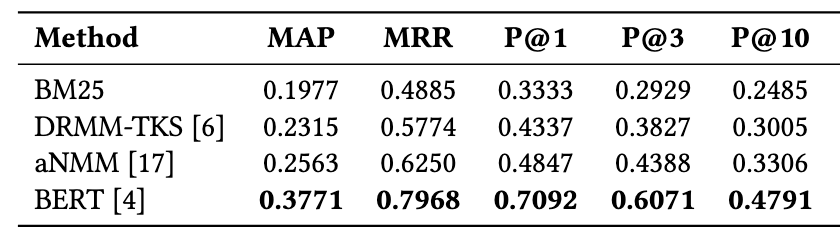